In [1]:
# !pip install kmodes


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
import pandas as pd
#Load the compact dataset
df = pd.read_parquet("mushroom_compact.parquet", engine="fastparquet")

cols_to_drop = [
    "cap-surface",
    "gill-attachment",
    "gill-spacing",
    "stem-root",
    "stem-surface",
    "veil-type",
    "veil-color",
    "spore-print-color",]
df_model = df.drop(columns=cols_to_drop).copy()

#remove numeric features for chi-square
df_km = df_model.drop(columns=["cap-diameter", "stem-height", "stem-width"])

In [3]:
#convert everything to string and fill NaNs
df_km = df_km.astype(str).fillna("missing")

In [4]:
#sample for workable dataset

df_km_sample = df_km.sample(n=50000, random_state=42)

df_km_sample.head()

,class,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,ring-type,habitat,season
6582897,p,c,w,t,p,w,f,f,g,s
603267,p,f,n,f,n,n,t,f,d,u
4700054,p,f,o,f,o,o,f,f,g,u
6581571,p,x,n,f,n,n,f,f,h,a
2746629,p,x,g,t,u,g,f,f,d,a


In [5]:
#find the best k
costs = []
K = range(2, 10)

for k in K:
    km = KModes(n_clusters=k, init="Huang", n_init=3, verbose=0)
    clusters = km.fit_predict(df_km_sample)
    costs.append(km.cost_)

costs


[np.float64(189919.0),
 np.float64(181075.0),
 np.float64(175312.0),
 np.float64(164119.0),
 np.float64(163873.0),
 np.float64(156483.0),
 np.float64(158787.0),
 np.float64(150471.0)]

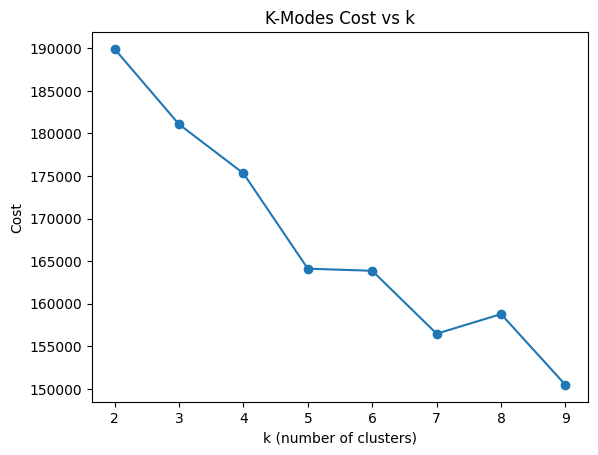

In [6]:
#plot to choose
plt.plot(K, costs, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Cost")
plt.title("K-Modes Cost vs k")
plt.show()

In [7]:
#choosing k=5 fit the kmodes model
km_final = KModes(n_clusters=4, init="Huang", n_init=5, verbose=1)
clusters = km_final.fit_predict(df_km_sample)




Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2780, cost: 180127.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 17249, cost: 178088.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 15095, cost: 178009.0
Run 3, iteration: 2/100, moves: 905, cost: 178009.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 16329, cost: 174706.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 17344, cost: 183124.0
Run 5, iteration: 2/100, moves: 5041, cost: 183124.0
Best run was number 4


In [8]:
#look at centroids
centroids = pd.DataFrame(km_final.cluster_centroids_, columns=df_km_sample.columns)
centroids


,class,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,ring-type,habitat,season
0,e,x,n,f,w,n,f,f,d,a
1,e,f,w,f,w,w,f,f,d,a
2,p,x,n,f,y,w,f,f,d,a
3,p,x,n,f,n,n,t,f,d,u


In [9]:
#cluster labels
df_km_sample["cluster"] = clusters
df_km_sample.head()


,class,cap-shape,cap-color,does-bruise-or-bleed,gill-color,stem-color,has-ring,ring-type,habitat,season,cluster
6582897,p,c,w,t,p,w,f,f,g,s,1
603267,p,f,n,f,n,n,t,f,d,u,3
4700054,p,f,o,f,o,o,f,f,g,u,1
6581571,p,x,n,f,n,n,f,f,h,a,0
2746629,p,x,g,t,u,g,f,f,d,a,2


In [11]:
#class distribution
df_km_sample.groupby("cluster")["class"].value_counts(normalize=True)


cluster  class
0        e        0.761328
         p        0.238672
1        e        0.599465
         p        0.400535
2        p        0.958450
         e        0.041550
3        p        0.880530
         e        0.119470
Name: proportion, dtype: float64